# CS613 Final Project: Image Classification 

In [2]:
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt

## Preprocessing

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')
    
def load_cifar10():
    train_data, train_labels = [] , []
    for i in range(1,6):
        batch = unpickle(f"data/cifar-10-python/cifar-10-batches-py/data_batch_{i}")
        train_data.append(batch[b'data'])
        train_labels.extend(batch[b'labels'])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.array(train_labels)

    # Load test batch
    test_batch = unpickle(f"data/cifar-10-python/cifar-10-batches-py/test_batch")
    test_data = np.array(test_batch[b'data'])
    test_labels = np.array(test_batch[b'labels'])

    # Reshape the data to (N, 32, 32, 3)
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return train_data, train_labels, test_data, test_labels

# Save data to CSV
def save_to_csv(data, labels, file_path):
    # Combine labels and data
    combined = np.column_stack((labels, data))
    # Save as a CSV file
    np.savetxt(file_path, combined, delimiter=",", fmt="%f")
    print(f"Saved {file_path} successfully!")
    
# Prepare data
def normalize_images(data):
    return data / 255.0

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size),labels] = 1
    return one_hot

In [4]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
x_train, y_train, x_test, y_test = load_cifar10()

# Preprocess data
print("Preprocessing data...")
x_train = normalize_images(x_train).reshape(x_train.shape[0], -1)
x_test = normalize_images(x_test).reshape(x_test.shape[0],-1)

Loading CIFAR-10 dataset...
Preprocessing data...


In [5]:
# Save csv files if needed
print("Saving to CSV...")
save_to_csv(x_train, y_train, "train.csv")
save_to_csv(x_test, y_test, "test.csv")
print("CSV files created.")

Saving to CSV...
Saved train.csv successfully!
Saved test.csv successfully!
CSV files created.


## Evaluation Functions

In [6]:
# Model Evaluation
def confusion_matrix(y_true, y_pred):
    num_classes = y_true.shape[1]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    y_true_indices = np.argmax(y_true, axis=1)
    
    for t, p in zip(y_true_indices, y_pred):
        cm[t, p] += 1
    
    return cm

def accuracy(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)  #Converting one-hot encoded back to label encoded
    return np.sum(y_true_label == y_pred) / len(y_true_label)


def precision(cm):
    
    precisions = []
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        if tp + fp > 0:
            precisions.append(tp / (tp + fp))
        else:
            precisions.append(0)
    return np.mean(precisions)

def recall(cm):
    
    recalls = []
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        if tp + fn > 0:
            recalls.append(tp / (tp + fn))
        else:
            recalls.append(0)
    return np.mean(recalls)

def f1_score(cm):
    
    precisions = precision(cm)
    recalls = recall(cm)
    
    if (precisions + recalls) > 0:
        return 2 * (precisions * recalls) / (precisions + recalls) 
    else:
        return 0

## Logistic Regression Implementation

In [7]:
class logistic_regression:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs

        #Weight Initalization
        self.num_features = None
        self.num_classes = None
        self.weights = None

        # Initialize lists for tracking losses
        self.train_losses = []
        self.test_losses = []

    # Logistic Regression Functions
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predictProb(self, X):
        y_pred = self.softmax(np.dot(X, self.weights))
        return y_pred
    
    def predict(self, y_pred):
        return np.argmax(self.predictProb(y_pred), axis=1)

    def log_loss(self, y, y_pred, epsilon=1e-15):
        return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    
    def categorical_crossentropy(self, y, y_pred, epsilon=1e-15):
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon) 
        return -np.mean(np.sum(y * np.log(y_pred), axis=1))
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def gradient_descent(self, X, y, weights, lr):
        y_pred = self.softmax(np.dot(X, weights))
        error = y_pred - y
        gradient = np.dot(X.T, error) / len(y)
        return weights - lr * gradient


    def fit(self, X_train, y_train, X_test=None, y_test=None):
        self.num_features = X_train.shape[1]
        self.num_classes = y_train.shape[1]
        self.weights = np.random.randn(self.num_features, self.num_classes)
    
        for epoch in range(self.epochs):
            # Update Weights
            self.weights = self.gradient_descent(X_train, y_train, self.weights, self.learning_rate)

            train_pred = self.softmax(np.dot(X_train, self.weights))
            train_loss = self.categorical_crossentropy(y_train, train_pred)
            self.train_losses.append(train_loss)

            if X_test is not None and y_test is not None:
                test_pred = self.softmax(np.dot(X_test, self.weights))
                test_loss = self.categorical_crossentropy(y_test, test_pred)
                self.test_losses.append(test_loss)
            else:
                test_loss = None

            # if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{self.epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

In [8]:
# Convert labels to one-hot encoding
num_classes = 10
y_train = one_hot_encode(y_train, num_classes)
y_test = one_hot_encode(y_test, num_classes)

# Add biases to X
X_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]

In [9]:
lr = logistic_regression(learning_rate=0.1, epochs=1000)


# Start timer
start_time = time.time()

# Fit the LR model

lr.fit(X_train, y_train, X_test, y_test)

# End timer and print elapsed time
elapsed_time = time.time() - start_time
print(f"Total runtime: {elapsed_time:.2f} seconds")


Epoch 1/1000: Train Loss = 20.9015, Test Loss = 20.9528
Epoch 2/1000: Train Loss = 18.2786, Test Loss = 18.3053
Epoch 3/1000: Train Loss = 17.0166, Test Loss = 17.0375
Epoch 4/1000: Train Loss = 16.4364, Test Loss = 16.4140
Epoch 5/1000: Train Loss = 16.1070, Test Loss = 16.0786
Epoch 6/1000: Train Loss = 15.9089, Test Loss = 15.8649
Epoch 7/1000: Train Loss = 15.7491, Test Loss = 15.7009
Epoch 8/1000: Train Loss = 15.6075, Test Loss = 15.5561
Epoch 9/1000: Train Loss = 15.4649, Test Loss = 15.4124
Epoch 10/1000: Train Loss = 15.3284, Test Loss = 15.2742
Epoch 11/1000: Train Loss = 15.1931, Test Loss = 15.1377
Epoch 12/1000: Train Loss = 15.0621, Test Loss = 15.0051
Epoch 13/1000: Train Loss = 14.9334, Test Loss = 14.8749
Epoch 14/1000: Train Loss = 14.8083, Test Loss = 14.7480
Epoch 15/1000: Train Loss = 14.6859, Test Loss = 14.6237
Epoch 16/1000: Train Loss = 14.5666, Test Loss = 14.5023
Epoch 17/1000: Train Loss = 14.4501, Test Loss = 14.3837
Epoch 18/1000: Train Loss = 14.3366, Tes

In [10]:
# Generate predictions for train and test sets
train_pred = lr.predict(X_train)

# Calculate training metrics
train_cm = confusion_matrix(y_train, train_pred)
train_accuracy = accuracy(y_train, train_pred)
train_precision = precision(train_cm)
train_recall = recall(train_cm)
train_f1 = f1_score(train_cm)

# Print Metrics
print("\nTraining Evaluation:")
print("Confusion Matrix:\n", train_cm)
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


test_pred = lr.predict(X_test)

test_cm = confusion_matrix(y_test, test_pred)
test_accuracy = accuracy(y_test, test_pred)
test_precision = precision(test_cm)
test_recall = recall(test_cm)
test_f1 = f1_score(test_cm)

print("\nValidation Evaluation:")
print("Confusion Matrix:\n", test_cm)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Training Evaluation:
Confusion Matrix:
 [[ 242  170  805  623  512   52  126  153 1721  596]
 [  74  917  496  695  375  124  255  132  893 1039]
 [  76  126 1327  857 1070  141  361  176  593  273]
 [  45  175  798 1455  658  293  456  179  496  445]
 [  30   84 1165  772 1379  154  500  257  355  304]
 [  33  154  875 1341  800  418  393  184  493  309]
 [  28  137  812  977  919  222 1088  174  338  305]
 [  54  165  843  858  960  165  388  686  375  506]
 [  77  187  447  460  231   64   82   58 2752  642]
 [  94  454  387  488  354   77  251  139  941 1815]]
Accuracy: 0.2416
Precision: 0.2648
Recall: 0.2416
F1 Score: 0.2527

Validation Evaluation:
Confusion Matrix:
 [[ 39  29 179 109  98  15  26  23 370 112]
 [ 12 168 112 131  71  35  52  17 187 215]
 [ 11  30 292 156 193  33  71  34 126  54]
 [ 11  37 161 290 132  63  80  28 120  78]
 [ 10  12 228 162 274  24 102  57  78  53]
 [ 11  31 170 276 153  79  72  43 111  54]
 [  4  31 155 201 184  37 220  44  65  59]
 [  8  40 170 153

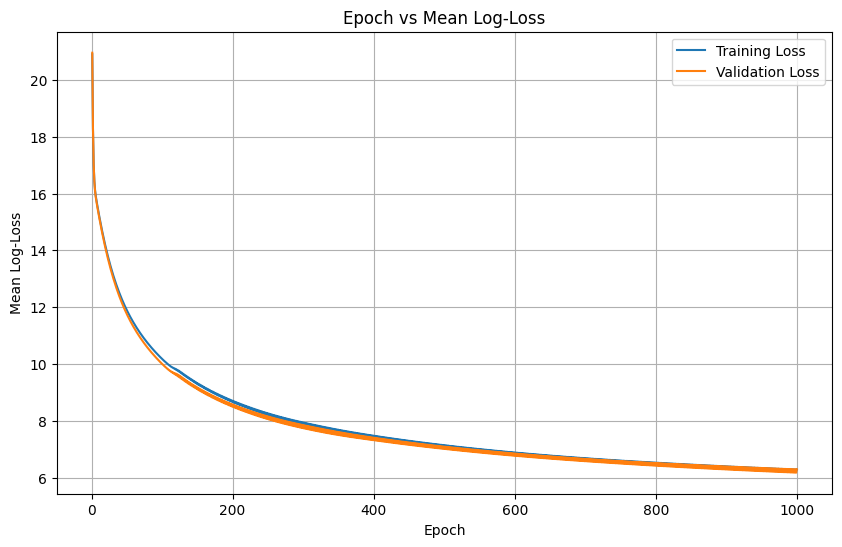

In [11]:
# Plot epoch vs log-loss
epochs = list(range(1, len(lr.train_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, lr.train_losses, label='Training Loss')
plt.plot(epochs, lr.test_losses, label='Validation Loss')

plt.title('Epoch vs Mean Log-Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Log-Loss')
plt.grid(True)
plt.legend()
plt.show()

## SVM Implementation

In [12]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_epochs=10):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_epochs = n_epochs
        self.weights = None
        self.accuracy_per_epoch = []

    def fit(self, X, y, num_classes, x_test = None, y_test = None):
        _, n_features = X.shape
        self.weights = np.zeros((num_classes, n_features))

        for epoch in range(self.n_epochs):
            for c in range(num_classes):
                y_binary = np.where(y == c, 1, -1)
                w = self.weights[c,:]
                
                for idx, x_i in enumerate(X):
                    condition = y_binary[idx] * (np.dot(x_i, w)) # Check if current sample passes margin condition
                    if condition >= 1:
                        w -= self.learning_rate * (2 * self.lambda_param * w)
                    else:
                        w -= self.learning_rate * (2 * self.lambda_param * w - x_i * y_binary[idx])
                            
                self.weights[c, :] = w
            
            # Evaluate after each epoch
            if x_test is not None and y_test is not None:
                y_pred = self.predict(x_test)
                accuracy = np.mean(y_pred == y_test)
                self.accuracy_per_epoch.append(accuracy)
                print(f"Epoch {epoch + 1}/{self.n_epochs} - Accuracy: {accuracy * 100:.2f}%")
    
    def predictProb(self, X):
        linear_output = np.dot(X, self.weights.T)
        return linear_output
    
    def predict(self, linear_output):
        return np.argmax(self.predictProb(linear_output), axis=1)

In [13]:


# Train the SVM
print("Training SVM...")
svm = SVM(learning_rate=1e-6, lambda_param=0.1, n_epochs=200)

# Decode labels from one-hot encoding to integers
y_train_decoded = np.argmax(y_train, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)

# Start timer
start_time = time.time()

# Fit the SVM model
svm.fit(X_train, y_train_decoded, num_classes, x_test=X_test, y_test=y_test_decoded)

# End timer and print elapsed time
elapsed_time = time.time() - start_time
print(f"Total runtime: {elapsed_time:.2f} seconds")

Training SVM...
Epoch 1/200 - Accuracy: 25.88%
Epoch 2/200 - Accuracy: 29.39%
Epoch 3/200 - Accuracy: 31.21%
Epoch 4/200 - Accuracy: 32.05%
Epoch 5/200 - Accuracy: 32.89%
Epoch 6/200 - Accuracy: 33.39%
Epoch 7/200 - Accuracy: 33.89%
Epoch 8/200 - Accuracy: 34.29%
Epoch 9/200 - Accuracy: 34.48%
Epoch 10/200 - Accuracy: 34.83%
Epoch 11/200 - Accuracy: 35.01%
Epoch 12/200 - Accuracy: 35.09%
Epoch 13/200 - Accuracy: 35.17%
Epoch 14/200 - Accuracy: 35.45%
Epoch 15/200 - Accuracy: 35.59%
Epoch 16/200 - Accuracy: 35.72%
Epoch 17/200 - Accuracy: 35.83%
Epoch 18/200 - Accuracy: 35.99%
Epoch 19/200 - Accuracy: 36.15%
Epoch 20/200 - Accuracy: 36.40%
Epoch 21/200 - Accuracy: 36.46%
Epoch 22/200 - Accuracy: 36.45%
Epoch 23/200 - Accuracy: 36.47%
Epoch 24/200 - Accuracy: 36.52%
Epoch 25/200 - Accuracy: 36.70%
Epoch 26/200 - Accuracy: 36.71%
Epoch 27/200 - Accuracy: 36.76%
Epoch 28/200 - Accuracy: 36.83%
Epoch 29/200 - Accuracy: 36.87%
Epoch 30/200 - Accuracy: 37.01%
Epoch 31/200 - Accuracy: 37.03%
E

In [14]:
# Evaluate the model
print("Evaluating SVM...")
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Training Metrics
train_cm_svm = confusion_matrix(y_train, y_pred_train)
train_accuracy_svm = accuracy(y_train, y_pred_train)
train_precision_svm = precision(train_cm_svm)
train_recall_svm = recall(train_cm_svm)
train_f1_svm = f1_score(train_cm_svm)

print("\nSVM Training Evaluation:")
print("Confusion Matrix:\n", train_cm_svm)
print(f"Accuracy: {train_accuracy_svm:.4f}")
print(f"Precision: {train_precision_svm:.4f}")
print(f"Recall: {train_recall_svm:.4f}")
print(f"F1 Score: {train_f1_svm:.4f}")

# Test Metrics
test_cm_svm = confusion_matrix(y_test, y_pred_test)
test_accuracy_svm = accuracy(y_test, y_pred_test)
test_precision_svm = precision(test_cm_svm)
test_recall_svm = recall(test_cm_svm)
test_f1_svm = f1_score(test_cm_svm)

print("\nSVM Validation Evaluation:")
print("Confusion Matrix:\n", test_cm_svm)
print(f"Accuracy: {test_accuracy_svm:.4f}")
print(f"Precision: {test_precision_svm:.4f}")
print(f"Recall: {test_recall_svm:.4f}")
print(f"F1 Score: {test_f1_svm:.4f}")

Evaluating SVM...

SVM Training Evaluation:
Confusion Matrix:
 [[2410  320   46  192   52  176  130  253  971  450]
 [ 310 2494   23  134   51  199  215  180  495  899]
 [ 760  287  636  521  420  590  812  473  327  174]
 [ 342  386  135 1353  114 1108  595  273  333  361]
 [ 454  197  297  364 1191  535  936  589  222  215]
 [ 231  286  222  830  181 1956  493  333  279  189]
 [ 140  291  122  659  304  489 2419  202  162  212]
 [ 258  326  107  359  352  451  279 2152  235  481]
 [ 797  410   21   97   19  226   57   87 2749  537]
 [ 293  884   24  120   34  152  156  174  567 2596]]
Accuracy: 0.3991
Precision: 0.3990
Recall: 0.3991
F1 Score: 0.3991

SVM Validation Evaluation:
Confusion Matrix:
 [[503  61  11  40  11  28  27  42 185  92]
 [ 63 486   5  30   7  44  42  35 118 170]
 [158  55 117 126  84 111 171  87  61  30]
 [ 65  76  38 270  26 229 104  53  57  82]
 [ 78  35  72  81 210 111 205 126  49  33]
 [ 49  50  50 166  38 376  87  83  71  30]
 [ 26  53  31 133  52  84 511  34 

## Ensemble Model

In [19]:
import numpy as np

class EnsembleModel:
    def __init__(self, models, weights):
        assert len(models) == len(weights), "Models and weights must have the same length"
        self.models = models
        self.weights = np.array(weights)
        self.weights /= np.sum(self.weights)  # Normalize weights

    def predictProb(self, X):
        weighted_probs = [
            model.predictProb(X) * weight
            for model, weight in zip(self.models, self.weights)
        ]
        avg_probs = np.sum(weighted_probs, axis=0)
        return avg_probs

    def predict(self, X):
        avg_probs = self.predictProb(X)
        return np.argmax(avg_probs, axis=1)


In [22]:
ensemble = EnsembleModel(models=[lr, svm], weights=[test_accuracy, test_accuracy_svm])

In [23]:
# Evaluate the Ensemble Model
y_pred_train = ensemble.predict(X_train)
y_pred_test = ensemble.predict(X_test)

# Training Metrics
train_cm_ensemble = confusion_matrix(y_train, y_pred_train)
train_accuracy_ensemble = accuracy(y_train, y_pred_train)
train_precision_ensemble = precision(train_cm_ensemble)
train_recall_ensemble = recall(train_cm_ensemble)
train_f1_ensemble = f1_score(train_cm_ensemble)

print("\nEnsemble Training Evaluation:")
print("Confusion Matrix:\n", train_cm_ensemble)
print(f"Accuracy: {train_accuracy_ensemble:.4f}")
print(f"Precision: {train_precision_ensemble:.4f}")
print(f"Recall: {train_recall_ensemble:.4f}")
print(f"F1 Score: {train_f1_ensemble:.4f}")

# Test Metrics
test_cm_ensemble = confusion_matrix(y_test, y_pred_test)
test_accuracy_ensemble = accuracy(y_test, y_pred_test)
test_precision_ensemble = precision(test_cm_ensemble)
test_recall_ensemble = recall(test_cm_ensemble)
test_f1_ensemble = f1_score(test_cm_ensemble)

print("\nEnsemble Validation Evaluation:")
print("Confusion Matrix:\n", test_cm_ensemble)
print(f"Accuracy: {test_accuracy_ensemble:.4f}")
print(f"Precision: {test_precision_ensemble:.4f}")
print(f"Recall: {test_recall_ensemble:.4f}")
print(f"F1 Score: {test_f1_ensemble:.4f}")



Ensemble Training Evaluation:
Confusion Matrix:
 [[ 414  181  712  601  428   53  117  156 1781  557]
 [  71 1206  409  615  310  112  238  124  858 1057]
 [  90  136 1305  861 1022  146  388  189  612  251]
 [  52  186  735 1546  607  327  468  179  472  428]
 [  41   84 1110  782 1399  156  526  273  350  279]
 [  34  153  825 1401  723  512  394  188  486  284]
 [  24  142  752  996  883  230 1199  172  314  288]
 [  57  170  770  832  912  169  353  852  364  521]
 [ 109  200  370  415  190   68   71   51 2910  616]
 [ 100  499  317  440  285   68  214  130  895 2052]]
Accuracy: 0.2679
Precision: 0.2987
Recall: 0.2679
F1 Score: 0.2825

Ensemble Validation Evaluation:
Confusion Matrix:
 [[ 71  30 166 109  84  15  21  22 375 107]
 [ 11 231 101 115  61  33  44  15 179 210]
 [ 14  29 281 170 190  33  72  39 125  47]
 [  9  40 144 309 128  72  79  31 112  76]
 [  9  11 216 165 288  25 102  60  76  48]
 [ 12  33 166 282 143  97  70  42 105  50]
 [  4  32 149 211 167  33 250  41  61  52]